In [1455]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.layers import LSTM,Dense,Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

In [1456]:
All_Games = pd.read_csv("All_Matches.csv")

In [1457]:
encoder = OneHotEncoder()
encoder_df = pd.DataFrame(encoder.fit_transform(All_Games[["Rank","Top_Current_Champ", "Jg_Current_Champ", "Mid_Current_Champ", "Bot_Current_Champ", "Sup_Current_Champ","Top_Enemy_Champ", "Jg_Enemy_Champ", "Mid_Enemy_Champ", "Bot_Enemy_Champ", "Sup_Enemy_Champ"]]).toarray())
# final_df = All_Games.join(encoder_df)


In [1458]:
encoder_df

,0,1,2,3,4,5,6,7,8,9,...,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1459]:
All_Games = All_Games.drop(["Rank","Top_Current_Champ", "Jg_Current_Champ", "Mid_Current_Champ", "Bot_Current_Champ", "Sup_Current_Champ","Top_Enemy_Champ", "Jg_Enemy_Champ", "Mid_Enemy_Champ", "Bot_Enemy_Champ", "Sup_Enemy_Champ"],axis=1)
#All_Games = All_Games.join(encoder_df)
All_Games = pd.DataFrame(np.hstack([All_Games, encoder_df]))

In [1460]:
All_Games

,0,1,2,3,4,5,6,7,8,9,...,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382
0,1.0,0.0,18.0,5.0,16.0,4.0,2.0,3.0,9.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,20.0,4.0,14.0,6.0,1.0,3.0,13.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,20.0,2.0,13.0,7.0,1.0,2.0,7.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,19.0,5.0,16.0,4.0,0.0,3.0,16.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,19.0,11.0,16.0,4.0,1.0,4.0,18.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1.0,1.0,18.0,2.0,9.0,11.0,1.0,3.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,1.0,19.0,11.0,13.0,7.0,2.0,5.0,11.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,1.0,0.0,13.0,5.0,10.0,10.0,0.0,1.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,1.0,0.0,18.0,1.0,10.0,10.0,0.0,1.0,20.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1461]:
All_Games = shuffle(All_Games)

In [1462]:
# X = one_hot_encoded_data.iloc[:,1:]
# y = one_hot_encoded_data.iloc[:,0]

X = All_Games.iloc[:,1:]
y = All_Games.iloc[:,0]



In [1463]:
X

,1,2,3,4,5,6,7,8,9,10,...,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382
13602,0.0,15.0,4.0,6.0,14.0,1.0,2.0,18.0,3.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3537,0.0,19.0,0.0,10.0,10.0,1.0,3.0,20.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4885,1.0,18.0,8.0,12.0,8.0,2.0,2.0,20.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6716,1.0,0.0,0.0,9.0,11.0,0.0,2.0,5.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8488,0.0,9.0,3.0,9.0,11.0,1.0,2.0,20.0,10.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13185,0.0,19.0,1.0,10.0,10.0,1.0,3.0,17.0,17.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7360,0.0,18.0,7.0,12.0,8.0,2.0,3.0,7.0,4.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8890,1.0,2.0,0.0,6.0,14.0,0.0,1.0,17.0,6.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,0.0,11.0,10.0,12.0,8.0,1.0,3.0,5.0,0.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1464]:
train_ratio = 0.80
test_ratio = 0.10
validation_ratio = 0.10

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_ratio)

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=validation_ratio/(train_ratio+test_ratio))


MemoryError: Unable to allocate 142. MiB for an array with shape (1382, 13500) and data type float64

In [ ]:
sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

In [ ]:
# opt = tf.keras.optimizers.Adagrad(
#     learning_rate=0.001,
#     initial_accumulator_value=0.1,
#     epsilon=1e-07,
#     name='Adagrad'
# )

In [ ]:
opt = tf.keras.optimizers.SGD(
    learning_rate=0.01,
    momentum=0.0,
    nesterov=False,
    name='SGD'
)

In [ ]:

model_one_hot = keras.Sequential() 

# model_one_hot.add(Dense(250, input_dim=X_train.shape[1], activation='relu')) 
# model_one_hot.add(Dropout(0.3))
# model_one_hot.add(Dense(250, activation='relu')) 
# model_one_hot.add(Dropout(0.3))
# model_one_hot.add(Dense(250, activation='relu')) 
# model_one_hot.add(Dropout(0.3))
# model_one_hot.add(Dense(250, activation='relu')) 
# model_one_hot.add(Dropout(0.3))
# model_one_hot.add(Dense(250, activation='relu')) 


model_one_hot.add(Dense(512, input_dim=X_train.shape[1], activation='relu')) 




model_one_hot.add(Dense(1, activation='sigmoid')) 

model_one_hot.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

model_one_hot.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_217 (Dense)           (None, 512)               708096    
                                                                 
 dense_218 (Dense)           (None, 1)                 513       
                                                                 
Total params: 708,609
Trainable params: 708,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#es = EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True)
es = EarlyStopping(monitor='val_acc', mode='max', patience=8, restore_best_weights=True)

In [ ]:
with tf.device('/GPU:0'):
    fit_model_one_hot = model_one_hot.fit(X_train, Y_train, validation_data=(X_valid,Y_valid), epochs=250, callbacks=es)

Epoch 1/250
375/375 [==============================] - 1s 3ms/step - loss: 0.6945 - acc: 0.5042 - val_loss: 0.6899 - val_acc: 0.5313
Epoch 2/250
375/375 [==============================] - 1s 2ms/step - loss: 0.6917 - acc: 0.5186 - val_loss: 0.6898 - val_acc: 0.5313
Epoch 3/250
375/375 [==============================] - 1s 2ms/step - loss: 0.6890 - acc: 0.5360 - val_loss: 0.6894 - val_acc: 0.5227
Epoch 4/250
375/375 [==============================] - 1s 3ms/step - loss: 0.6868 - acc: 0.5447 - val_loss: 0.6898 - val_acc: 0.5200
Epoch 5/250
375/375 [==============================] - 1s 3ms/step - loss: 0.6850 - acc: 0.5599 - val_loss: 0.6862 - val_acc: 0.5533
Epoch 6/250
375/375 [==============================] - 1s 3ms/step - loss: 0.6833 - acc: 0.5603 - val_loss: 0.6848 - val_acc: 0.5547
Epoch 7/250
375/375 [==============================] - 1s 3ms/step - loss: 0.6817 - acc: 0.5642 - val_loss: 0.6872 - val_acc: 0.5313
Epoch 8/250
375/375 [==============================] - 1s 3ms/step - 

In [ ]:
score = model_one_hot.evaluate(X_test, Y_test,verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.6868783235549927 / Test accuracy: 0.5373333096504211


In [ ]:
model_one_hot.save("KerasModel.h5")

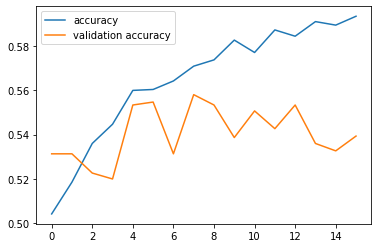

In [ ]:
plt.plot(fit_model_one_hot.history['acc'])
plt.plot(fit_model_one_hot.history['val_acc'])
plt.legend(['accuracy','validation accuracy'])

In [ ]:
joblib.dump(sc, 'MinMaxScaler.gz')
joblib.dump(encoder,'OneHotEncoder.joblib')

['OneHotEncoder.joblib']

In [ ]:
def ProcessLiveData(data):
    min_max_scaler = joblib.load('MinMaxScaler.gz')
    one_hot_encoder = joblib.load('OneHotEncoder.joblib')
    encoder_lobby = pd.DataFrame(one_hot_encoder.transform(data[["Rank","Top_Current_Champ", "Jg_Current_Champ", "Mid_Current_Champ", "Bot_Current_Champ", "Sup_Current_Champ","Top_Enemy_Champ", "Jg_Enemy_Champ", "Mid_Enemy_Champ", "Bot_Enemy_Champ", "Sup_Enemy_Champ"]]).toarray())
    data = data.join(encoder_lobby)
    data = data.drop(["Rank","Top_Current_Champ", "Jg_Current_Champ", "Mid_Current_Champ", "Bot_Current_Champ", "Sup_Current_Champ","Top_Enemy_Champ", "Jg_Enemy_Champ", "Mid_Enemy_Champ", "Bot_Enemy_Champ", "Sup_Enemy_Champ"],axis=1)
    data["Side"] = data["Side"].astype('category')
    data["Side"] = data["Side"].cat.codes
    data = min_max_scaler.transform(data)
    return data

In [ ]:
def Predict():
    model = load_model('KerasModel.h5')
    lobby =  pd.read_csv("lobby.csv")
    NewPredict = ProcessLiveData(lobby)
    return model.predict(NewPredict)[0,0]

In [ ]:
prediction = Predict()

C:\Users\Tigran\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
prediction

0.76875985